In [1]:
!pip install cur


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.extmath import randomized_svd
from tqdm.notebook import tqdm
from cur import cur
import warnings
warnings.filterwarnings('ignore')

# Stochastic CUR

In [45]:
#%%writefile CUR.py
import numpy as np
import pandas as pd
from sklearn.utils.extmath import randomized_svd

class CUR():
    def __init__(self, k, eps, it=None, truncated=False):
        self.k = k
        self.eps = eps
        self.trunc = truncated
        self.c = k * np.log(k) / eps**2 #expectation number of sampled columns
        self.C, self.U, self.R = None, None, None #matrices of decomposition
        self.pi_col, self.pi_row = None, None #leverage scores of corresponding columns/rows
        self.col_indices = None
        self.row_indices = None

    def column_select(self, A):
        n = A.shape[1]
        A = np.array(A.copy())
        if self.trunc:
            _, _, v_k = randomized_svd(A, self.k) #for very big matrices
        else:
            _, _, vh = np.linalg.svd(A, full_matrices=False)
            v_k = vh[0:self.k, :]

        pi = 1 / self.k * np.sum(v_k**2, axis=0)
        c_index = [np.random.choice(2,
                        p=[1 - min(1, self.c * pi[i]), min(1, self.c * pi[i])]) for i in range(n)
                  ]
        c_index = np.nonzero(c_index)[0]

        C = A[:, c_index]
        return C, c_index, pi

    def run_CUR(self, A):
        A = np.array(A.copy())
        self.C, self.col_indices, self.pi_col = self.column_select(A)
        self.R, self.row_indices, self.pi_row = self.column_select(A.T)
        self.U = np.linalg.pinv(self.C) @ A @ np.linalg.pinv(self.R.T)
        return self.C, self.U, self.R.T

# Functional representation

In [4]:
A = np.random.randn(10,8)


In [5]:
cur = CUR(k=2, eps=0.5,)


In [6]:
C,U,R = cur.run_CUR(A)
print(C.shape, U.shape, R.shape)


(10, 4) (4, 6) (6, 8)


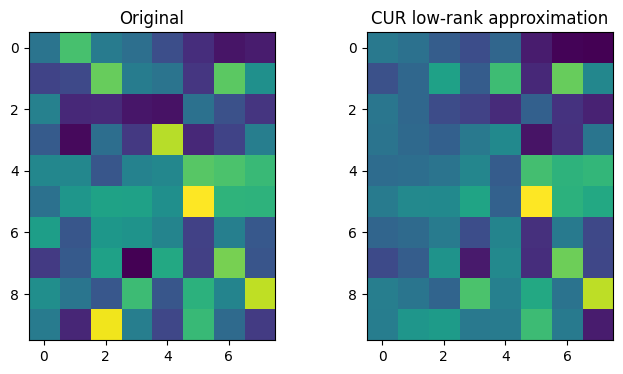

In [7]:
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.imshow(A)
plt.title('Original')

plt.subplot(122)
plt.imshow(C@U@R)
plt.title('CUR low-rank approximation')

plt.show()

# Kidney & Colon gene expression data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/palles77/DataPreprocessing/main/AP_Colon_Kidney.csv', index_col=0)


In [24]:
df.head()

,1007_s_at,121_at,1405_i_at,1438_at,1487_at,1494_f_at,1552256_a_at,1552257_a_at,1552274_at,1552275_s_at,...,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,Tissue
ID_REF,,,,,,,,,,,,,,,,,,,,,
203679,2883.2,2109.1,702.0,114.4,822.2,235.1,3346.1,815.1,233.3,218.4,...,2035.7,1908.1,30396.7,28371.7,85830.1,57084.9,3651.2,1736.1,2411.6,Kidney
179949,2607.4,1204.2,228.0,19.2,1497.1,167.6,23003.6,948.6,414.1,124.1,...,3811.6,3012.0,16748.8,13581.2,53322.5,37139.5,1648.1,502.9,890.6,Kidney
76558,2736.8,3912.2,1020.8,39.0,574.9,448.9,1337.9,605.6,176.8,411.9,...,17154.4,14835.5,64597.8,59311.2,203060.6,146422.6,3346.4,673.2,1499.3,Kidney
203712,1471.6,1318.2,4564.6,9.4,1426.5,105.2,2594.3,929.8,240.4,139.0,...,12382.2,11300.8,58551.7,49073.6,119460.8,95682.3,2553.5,961.2,1468.4,Kidney
102522,3564.7,2535.6,944.1,40.0,734.2,651.0,1490.5,712.3,632.7,185.0,...,13321.1,12966.9,54572.5,51049.1,178178.2,129533.2,3399.1,1209.8,1981.6,Kidney


In [5]:
X, y = df.drop('Tissue', axis=1), df['Tissue']
Xlog = np.log10(X + 1.0) #log expression data is more convenient to work

# SVD

In [6]:
X_log_centered = Xlog - Xlog.mean(0)
u,s,v = np.linalg.svd(X_log_centered)

In [7]:
k=2
X_svd = (u@np.diag(s))[:,:k]

In [8]:
X_svd

array([[-26.21411512,  -2.8370695 ],
       [-10.11563456,  -1.81203689],
       [-22.33323926,   0.56797398],
       ...,
       [ 24.00439873,  -8.11860768],
       [ 18.59365847,  -1.25420068],
       [ 16.57093553, -11.13434162]])

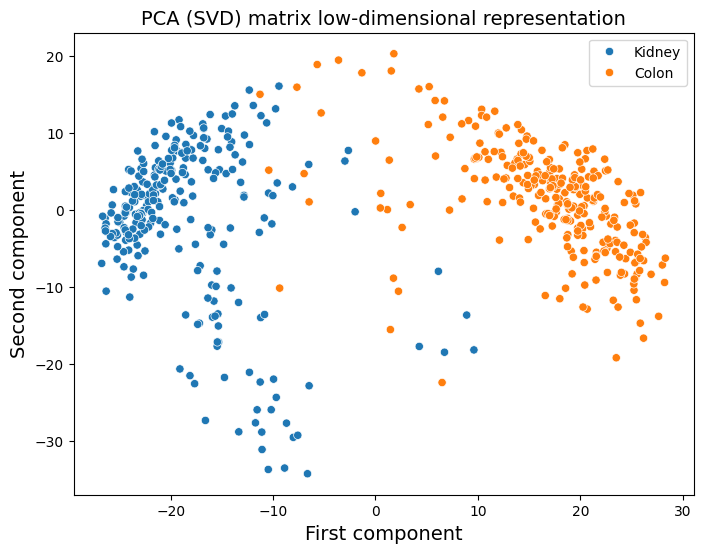

In [12]:

fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x=X_svd[:,0], y=X_svd[:,1], hue=y, ax=ax)
plt.title('PCA (SVD) matrix low-dimensional representation', fontsize=14)
plt.xlabel('First component', fontsize=14)
plt.ylabel('Second component', fontsize=14)
ax.legend()


plt.show()

# CUR

In [13]:
cur = CUR(2, 0.5, truncated=False)
C,U,R = cur.run_CUR(Xlog)
C.shape

(546, 4)

In [14]:
ids = np.argsort(cur.pi_col)[::-1][:5]
ids #top 5 genes by leverage score

array([4111, 9992, 3238, 1481, 2728])

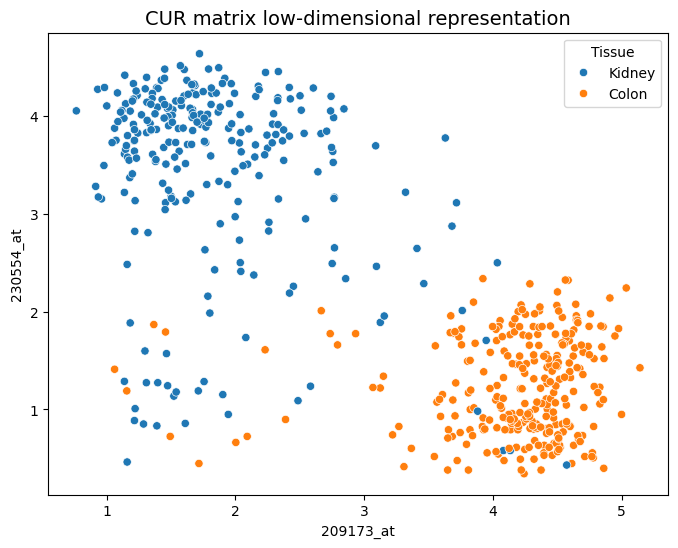

In [15]:
#plot 2 of them
fig, ax = plt.subplots(figsize=(8,6))
x1 = Xlog.iloc[:, ids[0]]
x2 = Xlog.iloc[:, ids[1]]
sns.scatterplot(x=x1, y=x2, hue=y, ax=ax)
plt.title('CUR matrix low-dimensional representation', fontsize=14)
plt.xlabel(x1.name)
plt.ylabel(x2.name)

plt.show()

In [16]:
#construct projection of data matrix on the space of selected columns
X_proj = C@np.linalg.pinv(C)@Xlog

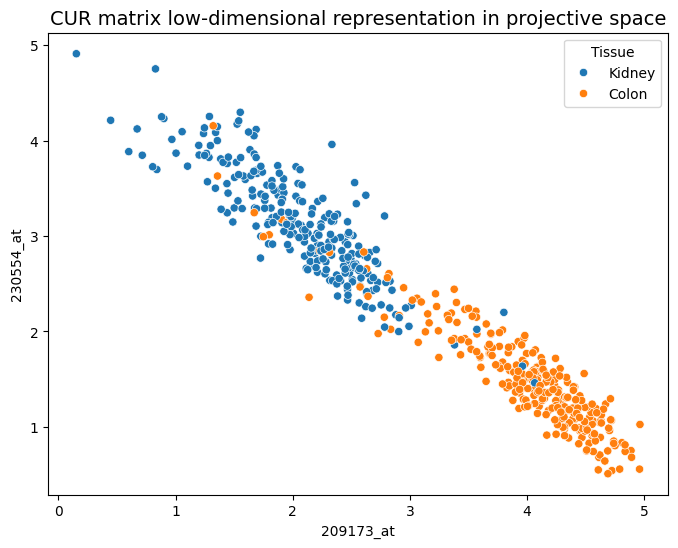

In [17]:
#plot 2 of them
fig, ax = plt.subplots(figsize=(8,6))
x1 = X_proj.iloc[:, ids[0]]
x2 = X_proj.iloc[:, ids[1]]
sns.scatterplot(x=np.array(x1), y=np.array(x2), hue=y, ax=ax)
plt.title('CUR matrix low-dimensional representation in projective space', fontsize=14)
plt.xlabel(x1.name)
plt.ylabel(x2.name)

plt.show()

In [18]:
import pandas as pd
import numpy as np

# Load the full dataset without setting an index
car_prices_df = pd.read_csv('https://gist.githubusercontent.com/palles77/38bd063939c1ac08b8d1e4f7c2c26abc/raw/b01ca987613684082b3897dd24e2f00909da6bd9/car_prices.csv')

# Drop specified columns
car_prices_df = car_prices_df.drop(['ID', 'Price', 'Doors'], axis=1)

# Replace '-' with '0' in the 'Levy' column
car_prices_df['Levy'] = car_prices_df['Levy'].replace('-', '0')
# Convert 'Levy' to an integer
car_prices_df['Levy'] = car_prices_df['Levy'].astype(int)

# Remove ' km' suffix from 'Mileage' and convert to integer
car_prices_df['Mileage'] = car_prices_df['Mileage'].str.replace(' km', '').astype(int)

# Convert the DataFrame to a NumPy array (excluding the header)
data_array = car_prices_df.to_numpy()

# Use the column names from the modified DataFrame
new_column_names = car_prices_df.columns

# Create a new DataFrame from the modified array
new_car_prices_df = pd.DataFrame(data_array, columns=new_column_names)

# Display the first 5 rows of the new DataFrame to verify
new_car_prices_df[0:5]

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Wheel,Color,Airbags
0,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,Left wheel,Silver,12
1,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000,6.0,Tiptronic,4x4,Left wheel,Black,8
2,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,Right-hand drive,Black,2
3,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,Left wheel,White,0
4,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,Left wheel,Silver,4


In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming 'new_car_prices_df' is your DataFrame loaded correctly
df = new_car_prices_df  # Using the DataFrame from your last manipulation

# Identify categorical columns - Example columns might include 'Color', 'Gear box type'
categorical_columns = ['Leather interior', 'Manufacturer', 'Model', 'Category', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column after filling missing values with 'Missing'
for column in categorical_columns:
    df[column] = df[column].fillna('Missing')  # Fill missing values
    df[column] = label_encoder.fit_transform(df[column])

# After encoding, check for any NaN values across the DataFrame and replace them with zero
df.fillna(0, inplace=True)

# Optionally, ensure all numeric columns are of a numeric type (int or float)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')
df.fillna(0, inplace=True)  # Replace any remaining NaNs that resulted from coercion errors with zero

# Display the first 5 rows of the DataFrame to verify the changes
print(df.head())

   Levy  Manufacturer  Model  Prod. year  Category  Leather interior  \
0  1399            32   1242        2010         4                 1   
1  1018             8    658        2011         4                 0   
2     0            21    684        2006         3                 0   
3   862            16    661        2011         4                 1   
4   446            21    684        2014         3                 1   

   Fuel type  Engine volume  Mileage  Cylinders  Gear box type  Drive wheels  \
0          2            3.5   186005        6.0              0             0   
1          5            3.0   192000        6.0              2             0   
2          5            1.3   200000        4.0              3             1   
3          2            2.5   168966        4.0              0             0   
4          5            1.3    91901        4.0              0             1   

   Wheel  Color  Airbags  
0      0     12       12  
1      0      1        8  
2    

In [20]:
import numpy as np
import pandas as pd

# Assuming `df` is your preprocessed DataFrame ready for CUR application

def cur_decomposition(A, k):
    # Step 1: Compute probabilities
    row_squared_norms = np.linalg.norm(A, axis=1)**2
    col_squared_norms = np.linalg.norm(A, axis=0)**2
    row_probs = row_squared_norms / row_squared_norms.sum()
    col_probs = col_squared_norms / col_squared_norms.sum()

    # Step 2: Randomly select k columns and rows based on their probabilities
    cols = np.random.choice(a=np.arange(A.shape[1]), size=k, replace=False, p=col_probs)
    rows = np.random.choice(a=np.arange(A.shape[0]), size=k, replace=False, p=row_probs)

    # Step 3: Construct matrices C, U, and R
    C = A[:, cols]
    R = A[rows, :]
    U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)

    return C, U, R

# Convert DataFrame to numpy array for processing
data_matrix = df.to_numpy()

# Apply CUR decomposition
num_features = 10  # For example, let's reduce to 10 features
C, U, R = cur_decomposition(data_matrix, num_features)

# You can use the matrix C (and R) directly as the reduced feature set
# If you want to revert back to a DataFrame for further analysis or use in ML models:
reduced_df = pd.DataFrame(C, columns=[f"Feature_{i}" for i in range(C.shape[1])])

reduced_df[0:5]

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9
0,186005.0,2010.0,1399.0,1242.0,32.0,12.0,12.0,2.0,6.0,4.0
1,192000.0,2011.0,1018.0,658.0,8.0,1.0,8.0,5.0,6.0,4.0
2,200000.0,2006.0,0.0,684.0,21.0,1.0,2.0,5.0,4.0,3.0
3,168966.0,2011.0,862.0,661.0,16.0,14.0,0.0,2.0,4.0,4.0
4,91901.0,2014.0,446.0,684.0,21.0,12.0,4.0,5.0,4.0,3.0


In [30]:
new_car_prices_df

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Wheel,Color,Airbags
0,1399,32,1242,2010,4,1,2,3.5,186005,6.0,0,0,0,12,12
1,1018,8,658,2011,4,0,5,3.0,192000,6.0,2,0,0,1,8
2,0,21,684,2006,3,0,5,1.3,200000,4.0,3,1,1,1,2
3,862,16,661,2011,4,1,2,2.5,168966,4.0,0,0,0,14,0
4,446,21,684,2014,3,1,5,1.3,91901,4.0,0,1,0,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,0,36,385,1999,1,1,0,0.0,300000,4.0,1,2,0,12,5
19233,831,23,1334,2011,9,1,5,2.4,161600,4.0,2,1,0,11,8
19234,836,23,1442,2010,4,1,1,2.0,116365,4.0,0,1,0,7,4
19235,1288,8,456,2007,4,1,1,2.0,51258,4.0,0,1,0,1,4


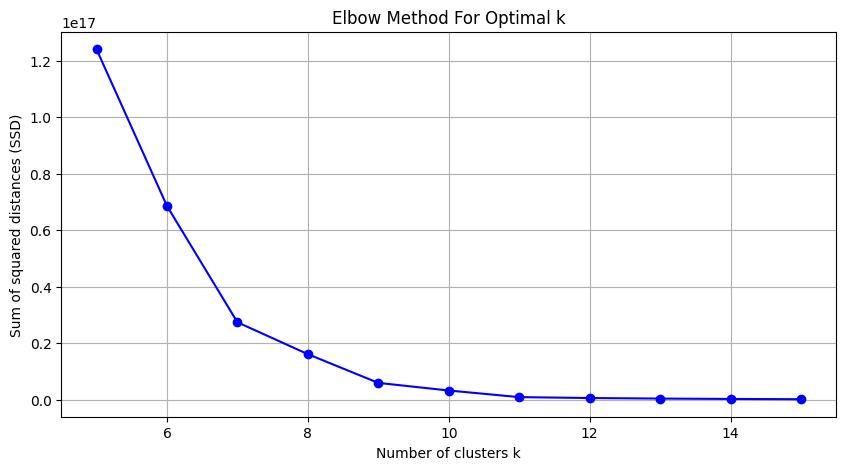

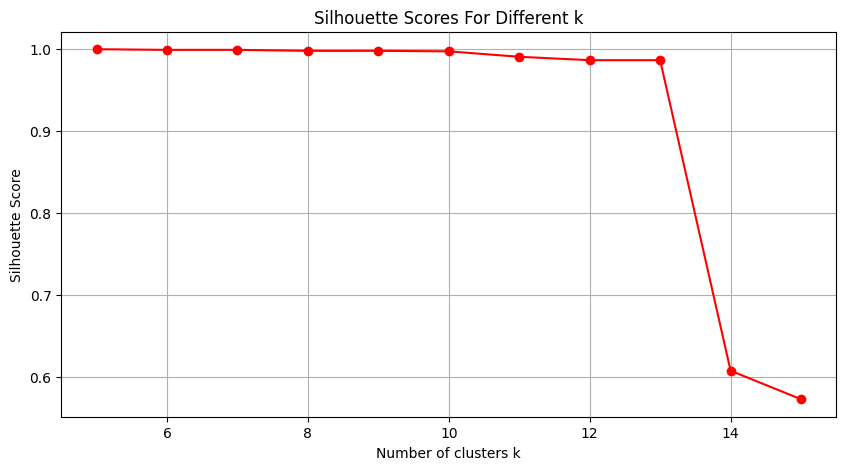

Silhouette Score for k=5: 0.9996
Silhouette Score for k=6: 0.9988
Silhouette Score for k=7: 0.9988
Silhouette Score for k=8: 0.9976
Silhouette Score for k=9: 0.9976
Silhouette Score for k=10: 0.9970
Silhouette Score for k=11: 0.9904
Silhouette Score for k=12: 0.9862
Silhouette Score for k=13: 0.9862
Silhouette Score for k=14: 0.6080
Silhouette Score for k=15: 0.5733


In [21]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming df is your DataFrame fully prepared for clustering
df = new_car_prices_df  # Let's assume this DataFrame is ready and preprocessed

# Variables to store results
ssd = []  # Sum of squared distances
silhouette_scores = []

# Range of k to try
k_range = range(5, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    ssd.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center

    # Compute the silhouette score, only if there are more than 1 cluster (silhouette score requires more than one cluster)
    if k > 1:
        sil_score = silhouette_score(df, kmeans.labels_)
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(None)

# Plotting the Elbow Method graph for SSD
plt.figure(figsize=(10, 5))
plt.plot(k_range, ssd, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distances (SSD)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# Plotting the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Different k')
plt.grid(True)
plt.show()

# Displaying the silhouette scores for review
for k, score in zip(k_range, silhouette_scores):
    print(f"Silhouette Score for k={k}: {score:.4f}")

# Dimension reduction CUR - for biological data (2columns)

In [55]:
def get_needed_col_dimension(dim: int, data_frame: pd.DataFrame):
    X, y = data_frame.drop('Tissue', axis=1), data_frame['Tissue']
    BIOLog = np.log10(X + 1.0)
    cur = CUR(2, 0.5, truncated=False)
    C, U, R = cur.run_CUR(BIOLog)
    print(f'Shape: {C.shape}')
    print(f'Required dim: {dim}')

    while C.shape[1] != dim:
        cur = CUR(2, 0.5, truncated=False)
        C, U, R = cur.run_CUR(BIOLog)
        print(f'Shape: {C.shape}')

    # Reconstruct the original matrix using CUR decomposition
    X_cur_reconstructed = C @ U @ R

    # Compute reconstruction error
    recon_error = np.mean(np.square(BIOLog - X_cur_reconstructed))

    return C, U, R, recon_error


In [54]:
df = pd.read_csv('https://raw.githubusercontent.com/palles77/DataPreprocessing/main/AP_Colon_Kidney.csv', index_col=0)

In [56]:
C, U, R, recon_error = get_needed_col_dimension(2, df)

Shape: (546, 11)
Required dim: 2
Shape: (546, 5)
Shape: (546, 2)


In [57]:
C.shape

(546, 2)

In [58]:
print(f'Recon error: {recon_error}')

Recon error: 0.13385936355892164


In [59]:
C

array([[2.89867034, 3.05568406],
       [2.9918018 , 3.31582346],
       [3.04155058, 3.00445035],
       ...,
       [3.08346679, 3.20117856],
       [3.1008184 , 3.10394049],
       [3.55935593, 3.03881879]])

In [60]:
C, U, R, recon_error = get_needed_col_dimension(5, df)

Shape: (546, 7)
Required dim: 5
Shape: (546, 7)
Shape: (546, 3)
Shape: (546, 7)
Shape: (546, 6)
Shape: (546, 5)


In [61]:
C.shape

(546, 5)

In [62]:
print(f'Recon error: {recon_error}')

Recon error: 0.1087325897579537


In [63]:
C

array([[2.14674801, 2.94180947, 3.54408045, 2.9240207 , 2.67255963],
       [2.79761373, 2.88558736, 3.55598873, 3.13811315, 2.02653326],
       [2.46538285, 2.65388756, 3.22248236, 3.22196165, 2.78922806],
       ...,
       [2.43759203, 3.45653304, 3.32306638, 2.52009033, 1.42488164],
       [2.73021684, 3.45147941, 3.18252878, 2.77728179, 2.36361198],
       [2.07518185, 3.32300445, 3.2278867 , 2.39075853, 1.39967372]])

# Dimension reduction CUR - for biological data (5columns)

In [26]:
df = pd.read_csv('https://raw.githubusercontent.com/palles77/DataPreprocessing/main/AP_Colon_Kidney.csv', index_col=0)

In [27]:
X, y = df.drop('Tissue', axis=1), df['Tissue']
BIOLog = np.log10(X + 1.0)

cur = CUR(2, 0.5, truncated=False)
C, U, R = cur.run_CUR(BIOLog)

In [28]:
print("Shape of matrix C - For Biological Data:", C.shape)

Shape of matrix C - For Biological Data: (546, 5)


In [29]:
C

array([[2.75602721, 2.8283376 , 2.50310944, 1.9571282 , 2.85394145],
       [1.1430148 , 3.6211555 , 2.81050135, 1.82801506, 2.92706224],
       [2.72156332, 3.03830217, 2.44901532, 1.48287358, 2.84571802],
       ...,
       [1.67577834, 3.4770923 , 3.11800003, 3.0949949 , 2.46493643],
       [2.27067884, 3.44923148, 2.84460142, 3.30198439, 2.45939249],
       [2.17868924, 3.42904133, 2.93166124, 4.12519164, 2.91576907]])

In [35]:
df = pd.read_csv('https://raw.githubusercontent.com/palles77/DataPreprocessing/main/AP_Colon_Kidney.csv', index_col=0)
X, y = df.drop('Tissue', axis=1), df['Tissue']
processed_df = X.select_dtypes(include=['float64', 'float32']) # Add more float types if needed
processed_df

,1007_s_at,121_at,1405_i_at,1438_at,1487_at,1494_f_at,1552256_a_at,1552257_a_at,1552274_at,1552275_s_at,...,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at
ID_REF,,,,,,,,,,,,,,,,,,,,,
203679,2883.2,2109.1,702.0,114.4,822.2,235.1,3346.1,815.1,233.3,218.4,...,2386.3,2035.7,1908.1,30396.7,28371.7,85830.1,57084.9,3651.2,1736.1,2411.6
179949,2607.4,1204.2,228.0,19.2,1497.1,167.6,23003.6,948.6,414.1,124.1,...,1225.7,3811.6,3012.0,16748.8,13581.2,53322.5,37139.5,1648.1,502.9,890.6
76558,2736.8,3912.2,1020.8,39.0,574.9,448.9,1337.9,605.6,176.8,411.9,...,5114.2,17154.4,14835.5,64597.8,59311.2,203060.6,146422.6,3346.4,673.2,1499.3
203712,1471.6,1318.2,4564.6,9.4,1426.5,105.2,2594.3,929.8,240.4,139.0,...,4579.8,12382.2,11300.8,58551.7,49073.6,119460.8,95682.3,2553.5,961.2,1468.4
102522,3564.7,2535.6,944.1,40.0,734.2,651.0,1490.5,712.3,632.7,185.0,...,5666.9,13321.1,12966.9,54572.5,51049.1,178178.2,129533.2,3399.1,1209.8,1981.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203733,3197.8,713.4,191.1,747.0,1597.8,179.5,1717.2,2261.2,305.5,181.8,...,1425.0,1752.1,1494.9,22165.4,20442.0,65246.8,46710.2,2057.3,810.0,1338.2
76548,2161.9,1244.3,2347.0,1995.6,697.8,194.6,508.4,1042.5,729.7,537.2,...,1663.2,5334.5,4588.2,21225.6,20067.2,80607.7,60204.9,1116.3,432.8,744.5
203731,4105.2,664.4,445.2,7008.2,1887.0,204.0,1951.8,2540.1,259.2,239.5,...,1145.6,1511.6,1318.0,19659.4,15774.8,56065.6,43347.8,1191.2,371.3,688.5


In [36]:
X.dtypes

1007_s_at              float64
121_at                 float64
1405_i_at              float64
1438_at                float64
1487_at                float64
                        ...   
AFFX-r2-P1-cre-3_at    float64
AFFX-r2-P1-cre-5_at    float64
AFFX-ThrX-3_at         float64
AFFX-ThrX-5_at         float64
AFFX-ThrX-M_at         float64
Length: 10935, dtype: object

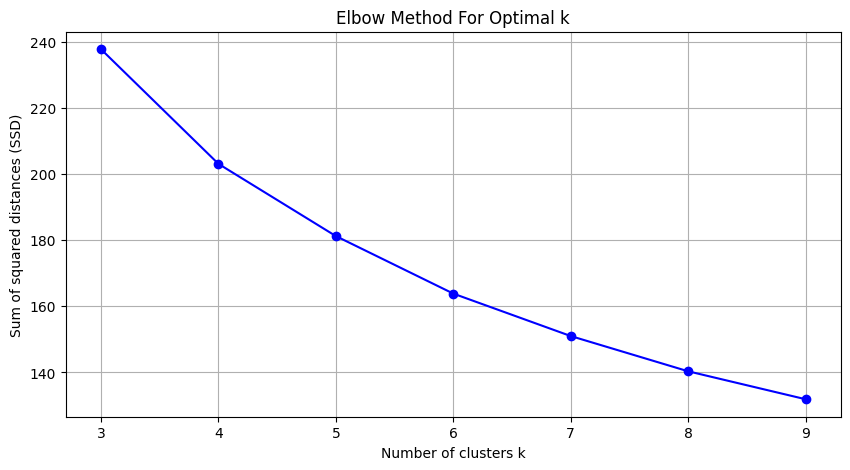

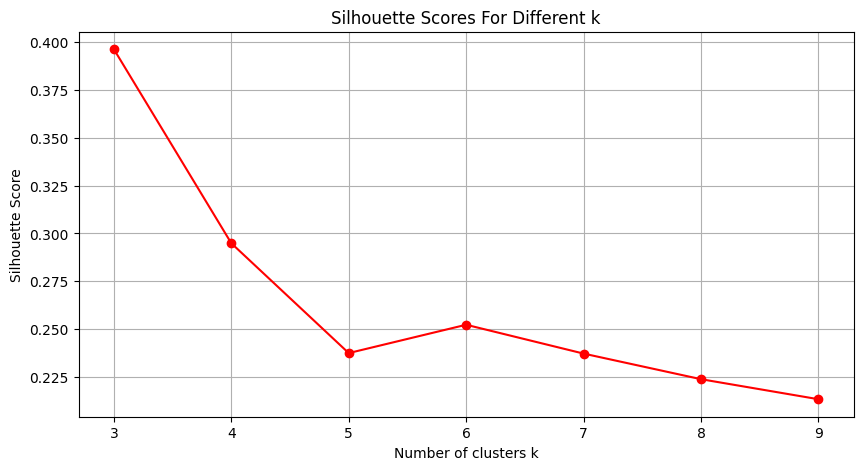

Silhouette Score for k=3: 0.3961
Silhouette Score for k=4: 0.2949
Silhouette Score for k=5: 0.2376
Silhouette Score for k=6: 0.2524
Silhouette Score for k=7: 0.2373
Silhouette Score for k=8: 0.2240
Silhouette Score for k=9: 0.2135


In [38]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

df = C

# Variables to store results
ssd = []  # Sum of squared distances
silhouette_scores = []

# Range of k to try
k_range = range(3, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    ssd.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center

    # Compute the silhouette score, only if there are more than 1 cluster (silhouette score requires more than one cluster)
    if k > 1:
        sil_score = silhouette_score(df, kmeans.labels_)
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(None)

# Plotting the Elbow Method graph for SSD
plt.figure(figsize=(10, 5))
plt.plot(k_range, ssd, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distances (SSD)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# Plotting the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Different k')
plt.grid(True)
plt.show()

# Displaying the silhouette scores for review
for k, score in zip(k_range, silhouette_scores):
    print(f"Silhouette Score for k={k}: {score:.4f}")

# Dimension reduction - for biological data (2columns)

In [35]:
df = pd.read_csv('https://raw.githubusercontent.com/palles77/DataPreprocessing/main/AP_Colon_Kidney.csv', index_col=0)

In [36]:
X, y = df.drop('Tissue', axis=1), df['Tissue']
Xlog = np.log10(X + 1.0) #log expression data is more convenient to work

In [37]:
X_log_centered = Xlog - Xlog.mean(0)
u,s,v = np.linalg.svd(X_log_centered)

In [38]:
k=2
X_svd = (u@np.diag(s))[:,:k]

In [39]:
X_svd

array([[-26.21411512,  -2.8370695 ],
       [-10.11563456,  -1.81203689],
       [-22.33323926,   0.56797398],
       ...,
       [ 24.00439873,  -8.11860768],
       [ 18.59365847,  -1.25420068],
       [ 16.57093553, -11.13434162]])

In [40]:
# Check for NaN values in the original data
if X_log_centered.isna().any().any():
    print("NaN values found in the data.")
else:
    # Compute SVD
    u, s, v = np.linalg.svd(X_log_centered)

    # Check for NaN values in the intermediate results
    if np.isnan(u).any() or np.isnan(s).any() or np.isnan(v).any():
        print("NaN values found in the SVD computation.")
    else:
        print("Shapes - u:", u.shape, "s:", s.shape, "v:", v.shape)

        # Compute reconstruction error
        # Compute reconstruction error
        X_reconstructed = u[:, :k] @ np.diag(s[:k]) @ v[:k, :]

        print("Shapes - X_reconstructed:", X_reconstructed.shape)

        # Check for NaN values in the reconstruction
        if np.isnan(X_reconstructed).any().any():
            print("NaN values found in the reconstruction.")
        else:
            reconstruction_error = np.mean(np.square(X_log_centered - X_reconstructed))
            print("Reconstruction Error:", reconstruction_error)


Shapes - u: (546, 546) s: (546,) v: (10935, 10935)
Shapes - X_reconstructed: (546, 10935)
Reconstruction Error: 0.06962632216831509


# Dimension reduction - for biological data (5columns)

In [21]:
df = pd.read_csv('https://raw.githubusercontent.com/palles77/DataPreprocessing/main/AP_Colon_Kidney.csv', index_col=0)

In [22]:
X, y = df.drop('Tissue', axis=1), df['Tissue']
Xlog = np.log10(X + 1.0) #log expression data is more convenient to work

In [23]:
X_log_centered = Xlog - Xlog.mean(0)
u,s,v = np.linalg.svd(X_log_centered)

In [24]:
k=5
X_svd = (u@np.diag(s))[:,:k]

In [25]:
X_svd

array([[-26.21411512,  -2.8370695 ,   8.8532894 ,  -0.41045369,
          0.05463046],
       [-10.11563456,  -1.81203689,   7.68537647,  11.86220563,
        -14.01493389],
       [-22.33323926,   0.56797398,   4.12716927,  -9.03760348,
         -3.86264872],
       ...,
       [ 24.00439873,  -8.11860768,   5.71377991,   2.38221215,
          1.62986993],
       [ 18.59365847,  -1.25420068,   2.13191864,  -2.3277987 ,
          7.24916303],
       [ 16.57093553, -11.13434162,   3.08378642,   3.02664106,
         -2.00797965]])

In [34]:
# Check for NaN values in the original data
if X_log_centered.isna().any().any():
    print("NaN values found in the data.")
else:
    # Compute SVD
    u, s, v = np.linalg.svd(X_log_centered)

    # Check for NaN values in the intermediate results
    if np.isnan(u).any() or np.isnan(s).any() or np.isnan(v).any():
        print("NaN values found in the SVD computation.")
    else:
        print("Shapes - u:", u.shape, "s:", s.shape, "v:", v.shape)

        # Compute reconstruction error
        # Compute reconstruction error
        X_reconstructed = u[:, :k] @ np.diag(s[:k]) @ v[:k, :]

        print("Shapes - X_reconstructed:", X_reconstructed.shape)

        # Check for NaN values in the reconstruction
        if np.isnan(X_reconstructed).any().any():
            print("NaN values found in the reconstruction.")
        else:
            reconstruction_error = np.mean(np.square(X_log_centered - X_reconstructed))
            print("Reconstruction Error:", reconstruction_error)


Shapes - u: (546, 546) s: (546,) v: (10935, 10935)
Shapes - X_reconstructed: (546, 10935)
Reconstruction Error: 0.05660306823739561


# Clustering SVD for k = 5

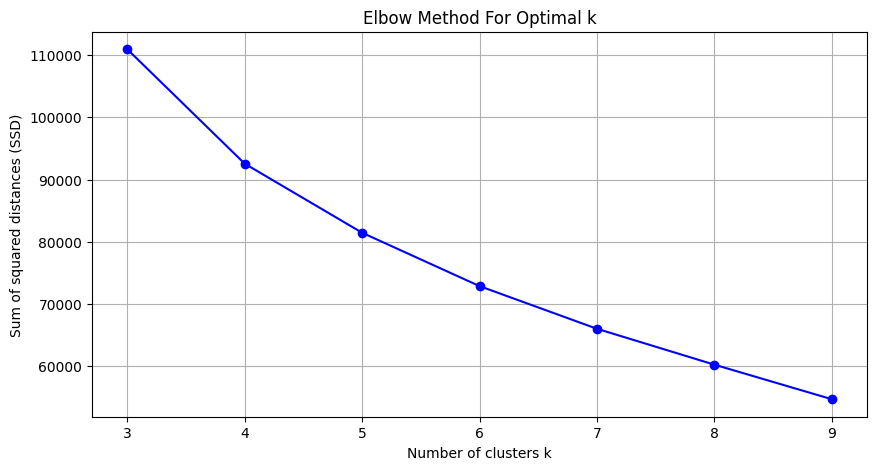

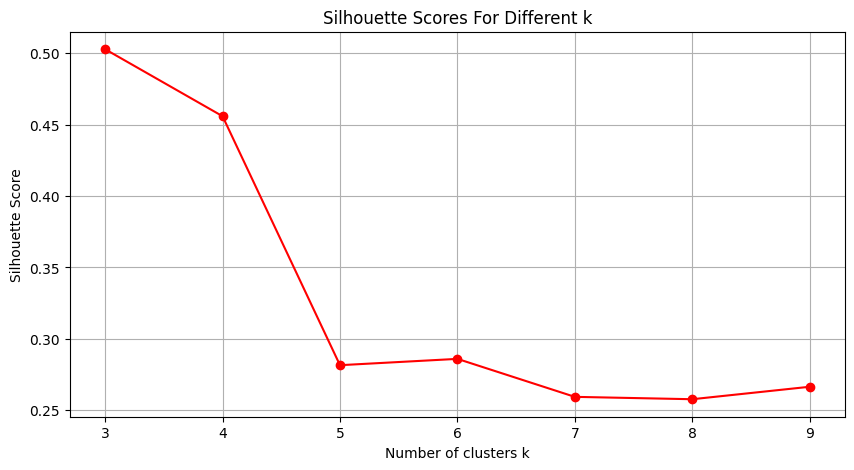

Silhouette Score for k=3: 0.5027
Silhouette Score for k=4: 0.4558
Silhouette Score for k=5: 0.2816
Silhouette Score for k=6: 0.2860
Silhouette Score for k=7: 0.2594
Silhouette Score for k=8: 0.2578
Silhouette Score for k=9: 0.2665


In [19]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

df = X_svd

# Variables to store results
ssd = []  # Sum of squared distances
silhouette_scores = []

# Range of k to try
k_range = range(3, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    ssd.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center

    # Compute the silhouette score, only if there are more than 1 cluster (silhouette score requires more than one cluster)
    if k > 1:
        sil_score = silhouette_score(df, kmeans.labels_)
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(None)

# Plotting the Elbow Method graph for SSD
plt.figure(figsize=(10, 5))
plt.plot(k_range, ssd, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distances (SSD)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# Plotting the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Different k')
plt.grid(True)
plt.show()

# Displaying the silhouette scores for review
for k, score in zip(k_range, silhouette_scores):
    print(f"Silhouette Score for k={k}: {score:.4f}")